In [1]:
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.8.2
Found GPU at: /device:GPU:0

Mon Aug 15 18:36:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    284MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [2]:
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)
    
dataset_file = '/tmp/tweets.csv'
download_file_from_google_drive('1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6', dataset_file)


In [3]:
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  plt.show() 

In [4]:
import pandas as pd

tweets = pd.read_csv(dataset_file, )
tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [5]:
print('Initial amount of Tweets:',len(tweets))
tweets.drop(tweets[tweets.isRetweet == 't'].index, inplace=True)
tweets.drop(tweets[tweets.favorites < 1e4].index, inplace=True)
tweets.text = tweets.text.str.lower()
tweets.text.replace(regex=r'https?:\/\/(www\.)?[-a-z0-9@:%._\+~#=]{1,256}\.[a-z0-9()]{1,6}\b([-a-z0-9()@:%_\+.~#?&\/=]*)', value='', inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('"""')].index, inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('"via ')].index, inplace=True)
tweets.text.replace(regex=r'[^a-z0-9,. ]', value='', inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('    ')].index, inplace=True)
tweets.drop(tweets[tweets.text.map(len) < 50].index, inplace=True)
print('Remaining Tweets:',len(tweets))

Initial amount of Tweets: 56571
Remaining Tweets: 14847


In [6]:
tweets = tweets.text.to_list()

vocabulary = ['&'] + list(set(char for tweet in tweets for char in tweet))
print('{} unique characters'.format(len(vocabulary)))

40 unique characters


In [7]:
char2idx = {u:i for i, u in enumerate(vocabulary)}
idx2char = dict(map(reversed, char2idx.items()))

print(char2idx)
print(idx2char)

{'&': 0, 'j': 1, '7': 2, '6': 3, 'q': 4, '.': 5, 'l': 6, 'x': 7, 'y': 8, 's': 9, 'f': 10, 'b': 11, '8': 12, 'h': 13, 'p': 14, 't': 15, 'a': 16, 'z': 17, 'm': 18, 'v': 19, '4': 20, '0': 21, 'i': 22, 'o': 23, 'r': 24, 'c': 25, '3': 26, 'w': 27, ' ': 28, ',': 29, 'u': 30, '1': 31, 'e': 32, '5': 33, '2': 34, '9': 35, 'd': 36, 'g': 37, 'k': 38, 'n': 39}
{0: '&', 1: 'j', 2: '7', 3: '6', 4: 'q', 5: '.', 6: 'l', 7: 'x', 8: 'y', 9: 's', 10: 'f', 11: 'b', 12: '8', 13: 'h', 14: 'p', 15: 't', 16: 'a', 17: 'z', 18: 'm', 19: 'v', 20: '4', 21: '0', 22: 'i', 23: 'o', 24: 'r', 25: 'c', 26: '3', 27: 'w', 28: ' ', 29: ',', 30: 'u', 31: '1', 32: 'e', 33: '5', 34: '2', 35: '9', 36: 'd', 37: 'g', 38: 'k', 39: 'n'}


In [8]:
def sequence_to_text(sequence):
  text = [idx2char.get(char_idx) for char_idx in np.array(sequence) if char_idx]
  return ''.join(text)

def text_to_sequence(text):
  sequence = [char2idx.get(char) for char in text]
  return sequence

print(text_to_sequence('foo bar'))
print(sequence_to_text(text_to_sequence('foo bar')))

[10, 23, 23, 28, 11, 16, 24]
foo bar


# Multi Layer Perceptron

In [9]:
seq_length_mlp = 16

combined_text = ' '.join([tweet for tweet in tweets])
combined_sequence = text_to_sequence(combined_text)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(combined_sequence)
sequences_mlp = dataset.batch(seq_length_mlp+1, drop_remainder=True)

In [11]:
def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[-1]
  return input_sequence, target_sequence

dataset_mlp = sequences_mlp.map(split_input_target)
dataset_mlp

<MapDataset element_spec=(TensorSpec(shape=(16,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [12]:
for input_sample, target_sample in dataset_mlp.take(5):
  print('Input sample: "{}"'.format(sequence_to_text(input_sample)))
  print('Target sample: "{}"'.format(sequence_to_text([target_sample])))
  print()

Input sample: "i was thrilled t"
Target sample: "o"

Input sample: " be back in the "
Target sample: "g"

Input sample: "reat city of cha"
Target sample: "r"

Input sample: "lotte, north car"
Target sample: "o"

Input sample: "lina with thousa"
Target sample: "n"



In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset_mlp = dataset_mlp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_mlp

<BatchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_mlp(vocabulary_size, embedding_dim, input_length, summary=True):

  inputs = layers.Input(shape=(input_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)
  x = layers.Flatten()(x)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(.2)(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(.2)(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(.2)(x)
  out = layers.Dense(vocabulary_size,activation='softmax')(x)

  model = Model(inputs, out, name='multi_layer_perceptron')
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

In [15]:
EMBEDDING_DIM = 32
VOCABULARY_SIZE = len(vocabulary)

mlp_model = build_model_mlp(VOCABULARY_SIZE, EMBEDDING_DIM, seq_length_mlp)
mlp_history = mlp_model.fit(dataset_mlp, 
                            epochs=30)

Model: "multi_layer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 32)            1280      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/30
2414/2414 [==============================] - 19s 6ms/step - loss: 2.1540 - accuracy: 0.3708
Epoch 2/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.7465 - accuracy: 0.4822
Epoch 3/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.5503 - accuracy: 0.5337
Epoch 4/30
2414/2414 [==============================] - 15s 6ms/step - loss: 1.4174 - accuracy: 0.5694
Epoch 5/30
2414/2414 [==============================] - 17s 7ms/step - loss: 1.3131 - accuracy: 0.5953
Epoch 6/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.2298 - accuracy: 0.6186
Epoch 7/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.1621 - accuracy: 0.6378
Epoch 8/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.1049 - accuracy: 0.6522
Epoch 9/30
2414/2414 [==============================] - 16s 6ms/step - loss: 1.0527 - accuracy: 0.6691
Epoch 10/30
2414/2414 [==============================] - 16s 6ms/ste

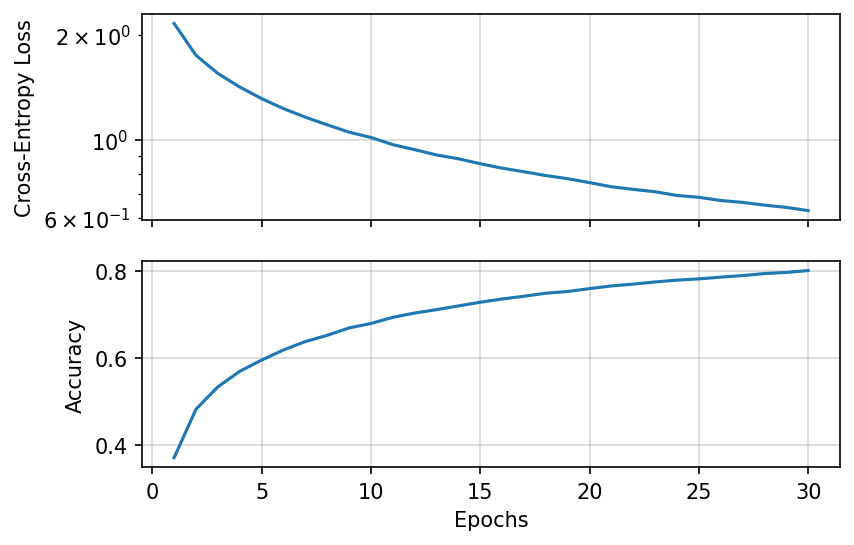

In [16]:
plot_history(mlp_history)

In [17]:
def generate_text_mlp(model, start_string, num_generate = 100):
  seed_sequence = text_to_sequence(start_string)
  generated_text = seed_sequence

  for i in range(num_generate):
    seed_sequence = tf.expand_dims(generated_text[-16:], 0)
    predictions = model(seed_sequence)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = np.argmax(predictions)
    generated_text.append(predicted_id)

  return sequence_to_text(generated_text)

In [18]:
print(generate_text_mlp(mlp_model, 'many are saying '))
print(generate_text_mlp(mlp_model, 'any are saying i')) 

many are saying the border wall very dishonest the dems have the bad wis for the strong stual, and theyre even crime
any are saying into our many that all amp, where will jobs before fraq couona, and his france of costs two with repu


# Fully Convolutional Network

In [19]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_cnn(vocabulary_size, embedding_dim, input_length, summary=True):

  inputs = layers.Input(shape=(input_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)

  x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
  x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
  x=layers.MaxPooling1D(strides=2)(x)
  x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
  x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
  x=layers.MaxPooling1D(strides=2)(x)
  x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
  x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)

  out = layers.Conv1D(vocabulary_size, x.shape[1], activation='softmax')(x)

  model = Model(inputs, out, name='fully_convolutional_model')

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

Model: "fully_convolutional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 16, 32)            1280      
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            24704     
                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2414/2414 [==============================] - 32s 9ms/step - loss: 2.3283 - accuracy: 0.1060
Epoch 2/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.8841 - accuracy: 0.0915
Epoch 3/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.7037 - accuracy: 0.0900
Epoch 4/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.5906 - accuracy: 0.0896
Epoch 5/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.5099 - accuracy: 0.0893
Epoch 6/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.4455 - accuracy: 0.0890
Epoch 7/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.3931 - accuracy: 0.0886
Epoch 8/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.3482 - accuracy: 0.0882
Epoch 9/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.3066 - accuracy: 0.0878
Epoch 10/30
2414/2414 [==============================] - 22s 9ms/step - loss: 1.2636

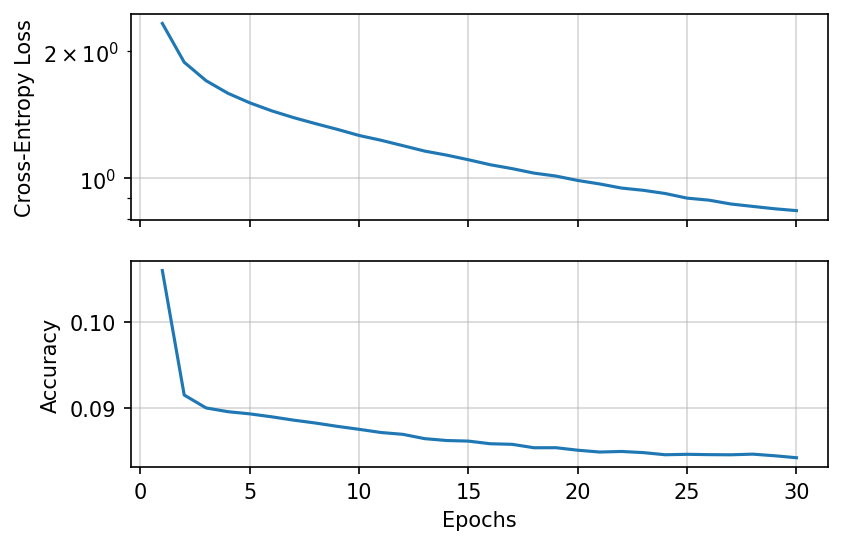

In [20]:
cnn_model = build_model_cnn(VOCABULARY_SIZE, EMBEDDING_DIM, seq_length_mlp)
cnn_history = cnn_model.fit(dataset_mlp,
                            epochs=30)
plot_history(cnn_history)

## Text Generation

In [21]:
print(generate_text_mlp(cnn_model, 'many are saying '))
print(generate_text_mlp(cnn_model, 'any are saying i')) # shift invariance
print(generate_text_mlp(cnn_model, 'many are saying im the')) # longer sequences

many are saying the fact that put the dems cleans a matter to we have to be deal 50 the lames of being pro medial, t
any are saying in begins a very will be happened a massive 147 mattem aver contround to crooked h. we will be a for 
many are saying im there are there thought a preper that despite the trump impeachment hoax am and the 2020 caple make a f


# Recurrent Neural Network

In [22]:
sequences = [text_to_sequence(tweet) for tweet in tweets]

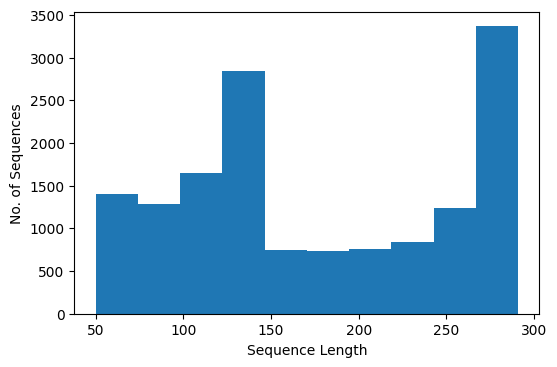

In [23]:
from matplotlib import pyplot as plt

plt.figure(dpi=100)
plt.hist([len(x) for x in sequences])
plt.xlabel('Sequence Length')
plt.ylabel('No. of Sequences')
plt.show()

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = pad_sequences(sequences, 
                          padding='post',
                          value=0)

In [25]:
dataset = tf.data.Dataset.from_tensor_slices(sequences)

for item in dataset.take(5):
  print(sequence_to_text(item))

print('\nSequence length:', sequences.shape[1])

i was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 
the unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this system, even though much smaller amp  with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots amp fraud
the threshold identification of ballots is turning out to be even bigger than originally anticipated. a very large number of ballots are impacted. stay tuned
im running as a proud democrat, for the senate. sleepy joe biden today. its only going to get worse. it is not sustainable for our county  china will own us
huge win today for the united states and for peace in the world. sudan has agreed to a peace and normalization agreement with israel with the united

In [26]:
def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[1:]
  return input_sequence, target_sequence

dataset = dataset.map(split_input_target)
print(dataset)

<MapDataset element_spec=(TensorSpec(shape=(290,), dtype=tf.int32, name=None), TensorSpec(shape=(290,), dtype=tf.int32, name=None))>


In [27]:
for input_sample, target_sample in dataset.take(3):
  print('Input sequence: "{}"'.format(sequence_to_text(input_sample)))
  print('Target sequence: "{}"'.format(sequence_to_text(target_sample)))
  print()

Input sequence: "i was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 "
Target sequence: " was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 "

Input sequence: "the unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this system, even though much smaller amp  with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots amp fraud"
Target sequence: "he unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this 

In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EMBEDDING_DIM = 32
VOCABULARY_SIZE = len(vocabulary)

In [29]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 290), dtype=tf.int32, name=None), TensorSpec(shape=(64, 290), dtype=tf.int32, name=None))>


In [30]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_gru(vocabulary_size, embedding_dim, batch_size, summary=True):
  
  inputs = layers.Input(batch_input_shape=(batch_size, None,))
  
  x = layers.Embedding(vocabulary_size,
                       embedding_dim)(inputs)

  x = layers.GRU(1024, return_sequences=True, stateful=False)(x)
  x = layers.Dropout(.2)(x)
  out = layers.Dense(vocabulary_size, activation='softmax')(x)

  model = Model(inputs, out, name='gated_recurrent_unit')

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

Model: "gated_recurrent_unit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, None)]              0         
                                                                 
 embedding_2 (Embedding)     (64, None, 32)            1280      
                                                                 
 gru (GRU)                   (64, None, 1024)          3250176   
                                                                 
 dropout_3 (Dropout)         (64, None, 1024)          0         
                                                                 
 dense_4 (Dense)             (64, None, 40)            41000     
                                                                 
Total params: 3,292,456
Trainable params: 3,292,456
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


231/231 [==============================] - 34s 135ms/step - loss: 1.9326 - accuracy: 0.4859
Epoch 2/30
231/231 [==============================] - 31s 135ms/step - loss: 1.4503 - accuracy: 0.5792
Epoch 3/30
231/231 [==============================] - 31s 133ms/step - loss: 1.3044 - accuracy: 0.6194
Epoch 4/30
231/231 [==============================] - 32s 136ms/step - loss: 1.1317 - accuracy: 0.6712
Epoch 5/30
231/231 [==============================] - 31s 134ms/step - loss: 0.9868 - accuracy: 0.7133
Epoch 6/30
231/231 [==============================] - 31s 135ms/step - loss: 0.8914 - accuracy: 0.7402
Epoch 7/30
231/231 [==============================] - 32s 135ms/step - loss: 0.8288 - accuracy: 0.7572
Epoch 8/30
231/231 [==============================] - 32s 136ms/step - loss: 0.7832 - accuracy: 0.7696
Epoch 9/30
231/231 [==============================] - 31s 135ms/step - loss: 0.7489 - accuracy: 0.7787
Epoch 10/30
231/231 [==============================] - 32s 135ms/step - loss: 0.7199

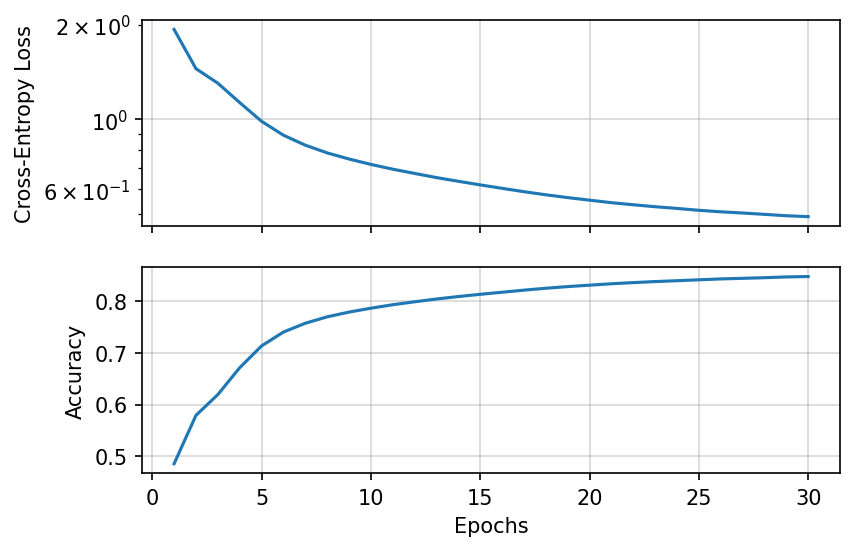

In [31]:
gru_model = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, BATCH_SIZE)
gru_history = gru_model.fit(dataset, 
                            epochs=30
                            )
plot_history(gru_history)

In [32]:
gru_history = gru_model.fit(dataset, 
                            epochs=30
                            )

Epoch 1/30
231/231 [==============================] - 31s 135ms/step - loss: 0.4878 - accuracy: 0.8485
Epoch 2/30
231/231 [==============================] - 31s 132ms/step - loss: 0.4841 - accuracy: 0.8494
Epoch 3/30
231/231 [==============================] - 31s 132ms/step - loss: 0.4812 - accuracy: 0.8502
Epoch 4/30
231/231 [==============================] - 31s 133ms/step - loss: 0.4782 - accuracy: 0.8511
Epoch 5/30
231/231 [==============================] - 31s 132ms/step - loss: 0.4757 - accuracy: 0.8517
Epoch 6/30
231/231 [==============================] - 31s 133ms/step - loss: 0.4724 - accuracy: 0.8525
Epoch 7/30
231/231 [==============================] - 31s 131ms/step - loss: 0.4705 - accuracy: 0.8530
Epoch 8/30
231/231 [==============================] - 31s 131ms/step - loss: 0.4683 - accuracy: 0.8536
Epoch 9/30
231/231 [==============================] - 31s 132ms/step - loss: 0.4663 - accuracy: 0.8540
Epoch 10/30
231/231 [==============================] - 31s 135ms/step - l

## Generate Text

In [33]:
weights_file = '/tmp/gru_model_weights'
gru_model.save_weights(weights_file)
tweety = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, 1)
tweety.load_weights(weights_file)

Model: "gated_recurrent_unit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, None)]               0         
                                                                 
 embedding_3 (Embedding)     (1, None, 32)             1280      
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3250176   
                                                                 
 dropout_4 (Dropout)         (1, None, 1024)           0         
                                                                 
 dense_5 (Dense)             (1, None, 40)             41000     
                                                                 
Total params: 3,292,456
Trainable params: 3,292,456
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
def generate_text(model, start_string, num_generate=100):
  seed_sequence = text_to_sequence(start_string)
  text_generated = seed_sequence
  seed_sequence = tf.expand_dims(seed_sequence, 0)
  model.reset_states()

  for i in range(num_generate):
    predictions = model(seed_sequence)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = np.argmax(predictions[-1,:])
    text_generated.append(predicted_id)
    seed_sequence = tf.expand_dims([predicted_id], 0)

  return sequence_to_text(text_generated)

In [35]:
print(generate_text(tweety, 'many are saying '))
print(generate_text(tweety, 'any are saying i'))
print(generate_text(tweety, 'many are saying im the'))
print(generate_text(tweety, 'many'))

many are saying thevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevevev
any are saying inononononononononononononononononononononononononononononononononononononononononononononononononono
many are saying im the wheveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveve
many wheveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveveve
